## Building a Sentiment Predicting Model on a Social Media Corpus

### Using the 1.6 Million Tweets Positive/Negative Sentiment Corpus


Helpful Resources:
https://medium.com/@thoszymkowiak/how-to-implement-sentiment-analysis-using-word-embedding-and-convolutional-neural-networks-on-keras-163197aef623

Good Post I found that most of this code is built off of
https://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html

Corpus (1.6million tweets as positive/negative)
https://drive.google.com/uc?id=0B04GJPshIjmPRnZManQwWEdTZjg&export=download




In [1]:
# Standard python helper libraries.
import collections
import itertools
import json
import os
import re
import sys
import time

# Numerical manipulation libraries.
import numpy as np
import pandas as pd
from scipy import stats
import scipy.optimize

# NLTK
import nltk
from nltk.tokenize import word_tokenize

# Helper libraries (from w266 Materials).
# import segment
#from shared_lib import utils
from shared_lib import vocabulary

# Machine Learning Packages
from sklearn.model_selection import train_test_split

# Word2Vec Model
import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Conv1D, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [3]:
# Pull in Tweet Data (Must be downloaded using https://github.com/seirasto/twitter_download)
# tweets = pd.read_csv("Data/milliontweetCorpus/training.1600000.processed.noemoticon.csv", header=None)
# tweets

cols = ['Sentiment', 'ItemID', 'DateTime', 'Query', 'SentimentSource', 'SentimentText']
# num_tweets = 1000000
tweets = pd.read_csv('Data/milliontweetCorpus/training.1600000.processed.noemoticon.csv', 
                     header=None, names=cols, encoding='ISO-8859-1', error_bad_lines=False) #, nrows=num_tweets)
tweets.drop(['ItemID', 'DateTime', 'Query', 'SentimentSource'], axis=1, inplace=True)
tweets = tweets[tweets.Sentiment.isnull() == False]
tweets['Sentiment'] = tweets['Sentiment'].map(int)
tweets = tweets[tweets['SentimentText'].isnull() == False]
tweets.reset_index(inplace=True)
tweets.drop('index', axis=1, inplace=True)
print('dataset loaded with shape', tweets.shape)
tweets[tweets['Sentiment'] == 0].head(5)
# SemEval Dataset is actually relatively small (6000 tweets in 2016). 
# We can group all of the Train/Test/Dev data from 2013 through 2016 to get more.
# Additionally, we could consider using this data which has 1.6 million rows but it is only a binary positive/negative class 
# https://drive.google.com/uc?id=0B04GJPshIjmPRnZManQwWEdTZjg&export=download

dataset loaded with shape (1600000, 2)


,Sentiment,SentimentText
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [18]:
# Print first 5 Negative Tweets (encoded as 0's)
for i,text in enumerate(tweets[tweets['Sentiment'] == 0]['SentimentText']):
    print('Negative Tweet:', text)
    if i >= 50:
        break
        
# Print first 5 Positive Tweets (encoded as 4's)
for i,text in enumerate(tweets[tweets['Sentiment'] == 4]['SentimentText']):
    print('Positive Tweet:', text)
    if i >= 14:
        break

Negative Tweet: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Negative Tweet: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Negative Tweet: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Negative Tweet: my whole body feels itchy and like its on fire 
Negative Tweet: @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
Negative Tweet: @Kwesidei not the whole crew 
Negative Tweet: Need a hug 
Negative Tweet: @LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?
Negative Tweet: @Tatiana_K nope they didn't have it 
Negative Tweet: @twittera que me muera ? 
Negative Tweet: spring break in plain city... it's snowing 
Negative Tweet: I just re-pierced my ears 
Negative Tweet: @caregiving I couldn't bear to watch i

### Cleaning

Good idea on using the tokenizer.  we can use this as a function with df.apply to speed this up! Check out the stack overflow solution below for some inspiration.  Some exploratory code is below

https://stackoverflow.com/questions/33098040/how-to-use-word-tokenize-in-data-frame

In [3]:
from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
t = TweetTokenizer()


def create_tokens(tweet):
    tweet = str(tweet.lower())
    tokens = t.tokenize(tweet)
    return tokens

tweets['SentimentTextTokenized'] = tweets['SentimentText'].apply(create_tokens)
tweets.head()


X = tweets.SentimentTextTokenized
Y = tweets.Sentiment

### Exploration

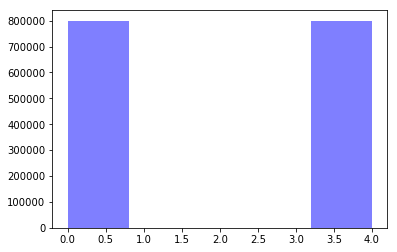

In [4]:

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
 
num_bins = 5
n, bins, patches = plt.hist(tweets.Sentiment, num_bins, facecolor='blue', alpha=0.5)
plt.show()

# Looks like there are only two categories in this Training Dataset. Negative = 0, Positive = 4

### Preprocessing & (future) Feature Engineering

### Split Train and Test Sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.20,random_state=100)
print(X_train[:10])
print(y_train[:10])

338461     [@sweetcandiesxxx, if, u, came, to, visit, her...
986385     [thanks, @just4julia, !, good, advice, for, th...
1301957    [@rogj, thank, you, ,, roger, !, oh, ,, and, v...
1003165    [@mattmazur, hi, matt, ,, how, are, you, today...
1369722       [@mrsnickjonass, that's, cool, ,, i, like, it]
1037256    [@oregonalmond, hi, hi, hi, !, !, !, ::, waves...
443905       [has, given, up, with, this, king, lear, shite]
119387     [i, want, all, my, friends, with, me, now, mis...
701129                   [@kookoobananas, i, have, to, work]
1143523    [@jamiecropley, http://twitpic.com/6arnd, -, y...
Name: SentimentTextTokenized, dtype: object
338461     0
986385     4
1301957    4
1003165    4
1369722    4
1037256    4
443905     0
119387     0
701129     0
1143523    4
Name: Sentiment, dtype: int64


### Word2Vec

In [6]:
# Convert each word into a vector representation. Couldn't get Keras working with straight indexes for each word so I followed the steps laid out here:
# https://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html

vec_dim = 100

tweet_w2v = Word2Vec(size=vec_dim, min_count=10) #vector size and minimum threshold to include for rare words
tweet_w2v.build_vocab(x for x in X_train)
tweet_w2v.train((x for x in X_train), total_examples=tweet_w2v.corpus_count, epochs=1)

13857658

In [7]:
tweet_w2v.most_similar('bad')

[('horrible', 0.6881661415100098),
 ('terrible', 0.6535442471504211),
 ('good', 0.6507218480110168),
 ('weird', 0.642382025718689),
 ('awful', 0.5921667218208313),
 ('painful', 0.5876110792160034),
 ('sad', 0.5844398736953735),
 ('weak', 0.5786687135696411),
 ('shitty', 0.5746874809265137),
 ('expensive', 0.5616201162338257)]

### Create Word Vectors 
https://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

print('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x for x in X_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('vocab size :', len(tfidf))

building tf-idf matrix ...
vocab size : 37635


In [9]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [10]:
from sklearn.preprocessing import StandardScaler

train_vecs_w2v = np.concatenate([buildWordVector(z, vec_dim) for z in map(lambda x: x, X_train)])

scaler = StandardScaler()
scaler.fit(train_vecs_w2v)
train_vecs_w2v = scaler.transform(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, vec_dim) for z in map(lambda x: x, X_test)])
test_vecs_w2v = scaler.transform(test_vecs_w2v)

In [11]:
# This section only needed if doing more than binary classification (multi-class)
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

print("Original Y:", y_train[:10])
encoder = LabelEncoder()
encoder.fit(Y)
y_train = encoder.transform(y_train)
y_test= encoder.transform(y_test)
print("Encoded Y:", y_train[:10])

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
print("One Hot Y:", y_train[:10])

Original Y: 338461     0
986385     4
1301957    4
1003165    4
1369722    4
1037256    4
443905     0
119387     0
701129     0
1143523    4
Name: Sentiment, dtype: int64
Encoded Y: [0 1 1 1 1 1 0 0 0 1]
One Hot Y: [[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]]


### CNN Model (really simple)

In [12]:
# Pad the sequence to the same length (this hurt accuracy?)
# train_vecs_w2v = sequence.pad_sequences(train_vecs_w2v, maxlen=vec_dim)
# test_vecs_w2v = sequence.pad_sequences(test_vecs_w2v, maxlen=vec_dim)

# Build Keras Model
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=vec_dim))
model.add(Dense(2, activation='softmax')) # softmax if multi-class
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', # categorical_crossentropy if multi-class
              metrics=['accuracy'])

model.fit(train_vecs_w2v, y_train, epochs=9, batch_size=32, verbose=2)

Epoch 1/9
 - 26s - loss: 0.4831 - acc: 0.7666
Epoch 2/9
 - 26s - loss: 0.4732 - acc: 0.7735
Epoch 3/9
 - 26s - loss: 0.4708 - acc: 0.7750
Epoch 4/9
 - 27s - loss: 0.4696 - acc: 0.7757
Epoch 5/9
 - 26s - loss: 0.4687 - acc: 0.7763
Epoch 6/9
 - 26s - loss: 0.4682 - acc: 0.7765
Epoch 7/9
 - 27s - loss: 0.4678 - acc: 0.7768
Epoch 8/9
 - 26s - loss: 0.4674 - acc: 0.7772
Epoch 9/9
 - 26s - loss: 0.4671 - acc: 0.7771


In [13]:
score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 77.60%


# Applied to Reddit

In [15]:
# Function to Predict Positive/Neutral/Negative

def prediction(text):
    sentiment = ["Negative", "Positive"]
    text = text.split() # Tokenize
    text = buildWordVector(text, vec_dim)
    text = scaler.transform(text)
    predic = model.predict(text, batch_size=32)
    result = sentiment[predic.argmax(axis=1)[0]]
    return result

In [16]:
import praw

#this is a read-only instance
reddit = praw.Reddit(user_agent='first_scrape (by /u/dswald)',
                     client_id='TyAK1zSuAvQjmA', 
                     client_secret="uxHGsL0zNODbowN6umVnBWpqLAQ")

subreddit = reddit.subreddit('portland')
hot_python = subreddit.hot(limit = 3) #need to view >2 to get past promoted posts

for submission in hot_python:
    if not submission.stickied: #top 2 are promoted posts, labeled as 'stickied'
        print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(submission.title,
                                                                          submission.ups,
                                                                          submission.downs,
                                                                          submission.visited))
        comments = submission.comments.list() #unstructured
        for comment in comments:
            print (20*'-')
            print ('Parent ID:', comment.parent())
            print ('Comment ID:', comment.id)
            print (comment.body)
            print("#"*10,'PREDICTED SENTIMENT:', prediction(comment.body),"#"*10)

Title: State prosecutors oppose bail for MAX murder suspect citing patrol car audio. "Get stabbed in your neck if you hate free speech… I can die in prison a happy man...I hope everyone stabbed died.”, ups: 239, downs: 0, Have we visited: False
--------------------
Parent ID: 7cyi47
Comment ID: dptlwb5
Seeing individuals defend this guy has been one of the more distasteful aspects of moderating /r/portland if I’m honest. 
########## PREDICTED SENTIMENT: Negative ##########
--------------------
Parent ID: 7cyi47
Comment ID: dpu30o6
I've dealt with Jeremy Christian twice. I used to work Loss Prevention for Whole Foods. One time he was walking around the Hollywood store, screaming out loud and being disruptive. I don't remember exactly what was said aside from some racist BS and tons of swearing. I kicked him out of the store. I remember very clearly being as calm as I could with him and asked him to leave. He pointed directly at me and yelled "There is a nigger right here!". I am white. 

Comment ID: dpu10tl
I got accused of victim blaming on that story of the cyclist getting killed where it turns out she was riding without lights, wearing dark clothing, with no helmet, and tanked... in the middle of the night... and saying that she bought her fate by making the decision to ride like that.  Not that she deserved to die or that it made me happy, but that she made decisions that directly led to her being killed.  Not the decision to be on a bike, not the decision to ride at night even... but all the other really fucking atrocious choices she obviously made.

No assholes, that's not victim blaming.  Victim blaming would be if I said she got it for riding her bike, period, which you can find ample examples of online and on this sub (which don't get deleted) on some of the stories where cyclists are hit/killed.  And definitely on O-live.  

If you sincerely can't tell the difference between those two things, and you're not just being willfully daft to get over on someone whe

AttributeError: 'MoreComments' object has no attribute 'parent'

It seems that everythng is positive or neutral.  Is this because of a unigram model or too specific training data or what?  This is food for thought.  Committing now.